In [1]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join('..', 'scripts'))
import figure_utils as utils
import lif_utils
from sspspace import HexagonalSSPSpace,SSPSpace,RandomSSPSpace
from pathintegration import PathIntegration
import scipy
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))


In [2]:
# Create SSP space
domain_dim = 2 # 2d x space
radius = 1 
bounds = radius*np.tile([-1,1],(domain_dim,1))
K = HexagonalSSPSpace(domain_dim, n_scales=12,n_rotates=12).phase_matrix
n_extra = 32
Knew = np.vstack([np.zeros((n_extra,domain_dim)), K, np.zeros((n_extra,domain_dim))])
ssp_space = SSPSpace(domain_dim, Knew.shape[0], phase_matrix=Knew,
                             domain_bounds=1.5*bounds, length_scale=1)
d = ssp_space.ssp_dim


sample_ssps,sample_points = ssp_space.get_sample_pts_and_ssps(100)
def get_path_info(ssp_path):
    sims = ssp_path @ sample_ssps.T
    max_sims = np.max(sims,axis=1)
    arg_max_sim = np.argmax(sims,axis=1)
    sim_path_est = sample_points[arg_max_sim,:]
    return max_sims, sim_path_est

t_space = HexagonalSSPSpace(1, n_scales=round((d-1)/4),n_rotates=1,
                 domain_bounds=np.array([[0,60]]), length_scale=1)
# t_space = RandomSSPSpace(1, ssp_dim=d,
#                  domain_bounds=np.array([[0,60]]), length_scale=1)
reordered_phases = np.fft.fftshift(t_space.phase_matrix,axes=0)[:d//2+1,:]


def _get_to_SSP_mat(D):
# Get matrix that transforms the D-dim FSSP from oscillators to a SSP
    W = np.fft.ifft(np.eye(D))
    W1 = W.real @ np.fft.ifftshift(np.eye(D),axes=0)
    W2 = W.imag @ np.fft.ifftshift(np.eye(D),axes=0)
    shiftmat1 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), np.flip(np.eye(D//2), axis=0)])
    shiftmat2 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), -np.flip(np.eye(D//2), axis=0)])
    shiftmat = np.vstack([ np.hstack([shiftmat1, np.zeros(shiftmat2.shape)]),
                          np.hstack([np.zeros(shiftmat2.shape), shiftmat2])])
    shiftmat = np.hstack([shiftmat, np.zeros((shiftmat.shape[0],1))])
    shiftmat[D//2,-1] = 1
    tr = np.hstack([W1, -W2]) @ shiftmat 
    return tr


def _get_from_SSP_mat(D):
# Get matrix that transforms a D-dim SSP to a FSSP in format needed for oscillators
    W = np.fft.fft(np.eye(D))
    W1 = np.fft.fftshift(np.eye(D),axes=0) @ W.real 
    W2 = np.fft.fftshift(np.eye(D),axes=0) @ W.imag 
    W1 = W1[:(D//2 + 1),:]
    W2 = W2[:(D//2 + 1),:]
    shiftmat = np.zeros((2*(D//2 + 1),2*(D//2 + 1)))
    shiftmat[0::2,:(D//2 + 1)] = np.eye(D//2 +1)
    shiftmat[1::2,(D//2 + 1):] = np.eye(D//2 +1)
    
    tr = shiftmat @ np.vstack([W1, W2]) 
    return tr

to_SSP = _get_to_SSP_mat(d)
from_SSP=_get_from_SSP_mat(d)

# Generate test path
T = 10
dt = 0.001
timesteps = np.arange(0, T, dt)
path = np.hstack([nengo.processes.WhiteSignal(20, high=.3, seed=3).run(T,dt=dt),
                  nengo.processes.WhiteSignal(20, high=.3, seed=5).run(T,dt=dt)])

shift_fun = lambda x, new_min, new_max: (new_max - new_min)*(x - np.min(x))/(np.max(x) - np.min(x))  + new_min
path[:,0] = shift_fun(path[:,0], -0.9*radius,0.9*radius)
path[:,1] = shift_fun(path[:,1], -0.9*radius,0.9*radius)

pathlen = path.shape[0]
vels = (1/dt)*( path[(np.minimum(np.floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
                path[(np.minimum(np.floor(timesteps/dt), pathlen-2)).astype(int),:])
max_v = np.max(np.abs(vels))
real_freqs = (ssp_space.phase_matrix @ vels.T)
scale_fac = 1/np.max(np.abs(real_freqs))
vels_scaled = vels*scale_fac
real_ssp = ssp_space.encode(path) 


In [3]:
n_oscs = d//2

real_ids = np.arange(0,n_oscs*2,2)
imag_ids = np.arange(1,n_oscs*2,2)
S_ids = np.zeros(n_oscs*2 + 1, dtype=int)
S_ids[0:d//2] = real_ids
S_ids[d//2:(n_oscs*2)] = imag_ids
S_ids[-1] = n_oscs*2

recurrent_tau=0.05

model = nengo.Network(seed=1)
with model:
    init_state = nengo.Node(lambda t: from_SSP @ real_ssp[int(t/dt)-1])
    
    tssp_int = nengo.networks.EnsembleArray(800, n_oscs + 1, 
                                               ens_dimensions = 2,
                                             radius=3,neuron_type=nengo.LIFRate())#RectifiedLinear
    nengo.Connection(init_state, tssp_int.input, synapse=None, transform=recurrent_tau)
    tssp_int.output.output = lambda t, x: x
    tssp_int.add_neuron_output()
    for i in np.arange(n_oscs+1):
        
        recur_mat = np.array([[0.999, recurrent_tau*(-reordered_phases[i,0] )],
                                [recurrent_tau*(reordered_phases[i,0]), 0.999]])
        nengo.Connection(tssp_int.ea_ensembles[i],tssp_int.ea_ensembles[i],
                 synapse=recurrent_tau, transform=recur_mat)
    
    tssp_out = nengo.Node(size_in=d)
    nengo.Connection(tssp_int.output[S_ids], tssp_out, 
                    transform = to_SSP, synapse=recurrent_tau)
    

    tssp_p = nengo.Probe(tssp_out, synapse=None)
    tssp2_p = nengo.Probe(tssp_int.output, synapse=recurrent_tau)
    tssp_n_p = nengo.Probe(tssp_int.neuron_output,  synapse=None)
 
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

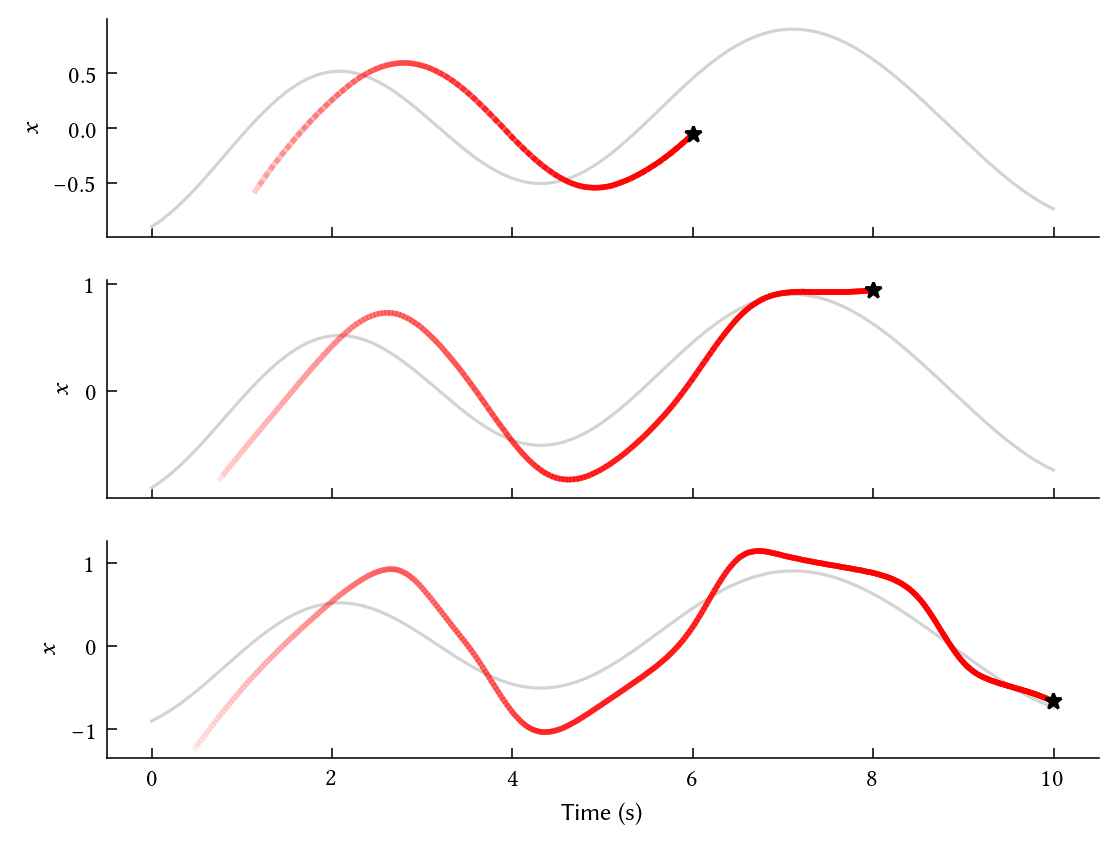

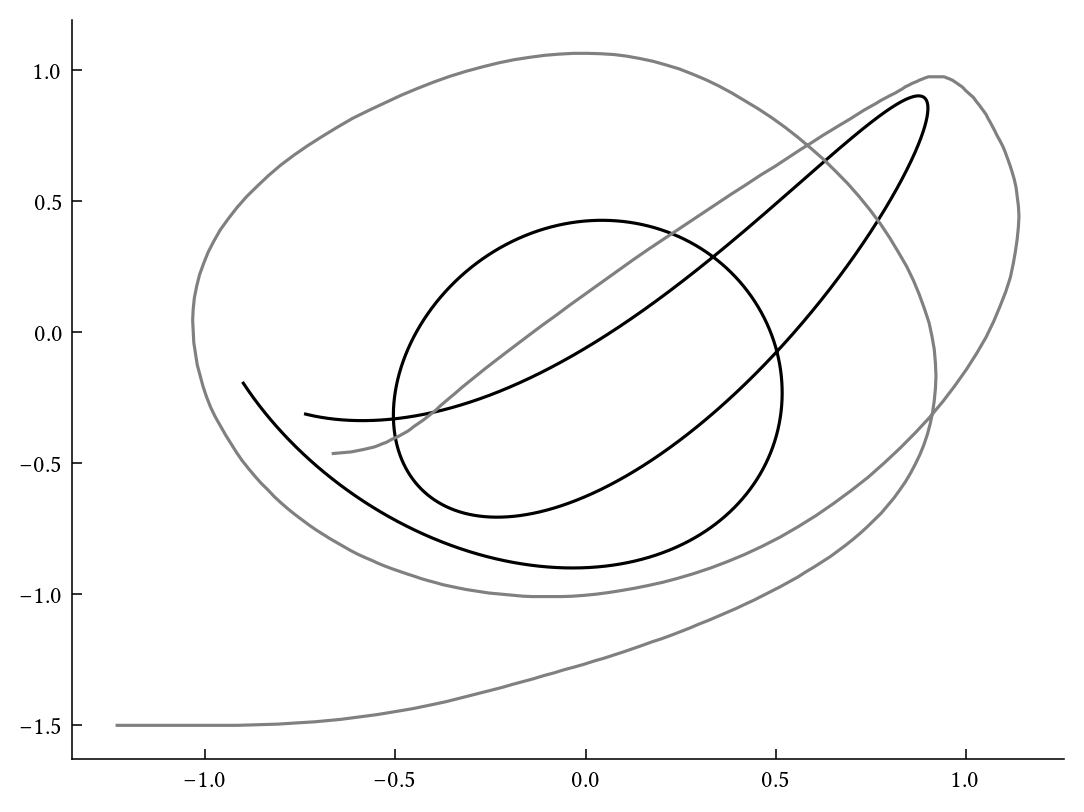

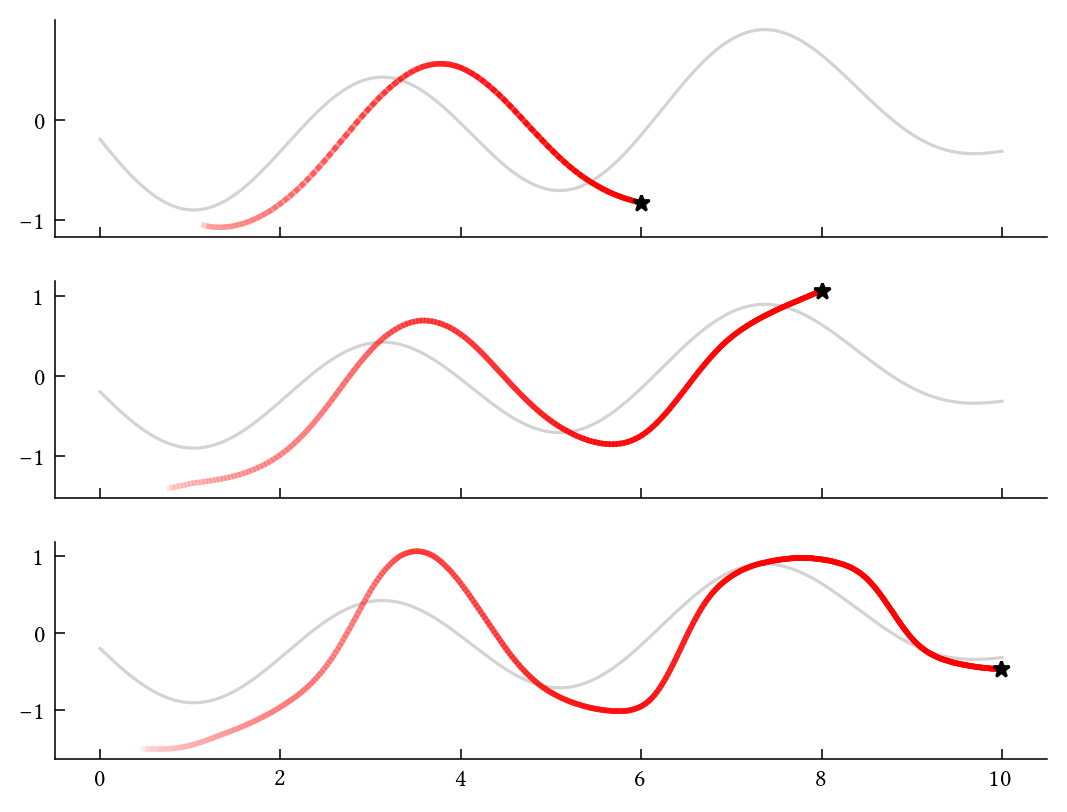

In [4]:
#fig=plt.figure()
#gs = fig.add_gridspec(1,3)
#plt.subplot(gs[0,2])

fig, axs = plt.subplots(nrows=3, sharex=True)

axs[0].plot(timesteps, path[:,0], color='lightgray')
axs[1].plot(timesteps, path[:,0], color='lightgray')
axs[2].plot(timesteps, path[:,0], color='lightgray')
axs[2].set_xlabel('Time (s)')
for i in range(3):
    axs[i].set_ylabel('$x$')

sample_times = np.array([int(0.6*T/dt), int(0.8*T/dt), int(T/dt)-10]) #np.array([int(0.3*T/dt), int(0.6*T/dt), int(T/dt)-10])
n_ts = 100*np.array([1,2,4])
n_ma= 20

all_trajs = []
all_trajs2 = []
all_decode_times = []
all_decode_times2 = []
for j, i in enumerate(sample_times):
    
    decode_times = np.linspace(0,-i*dt ,n_ts[j],endpoint=True)#np.max([-i*dt + 0.1, -8])
    alphas = np.linspace(1, 0, n_ts[j])
    
    traj = np.zeros((n_ts[j], domain_dim))
    for k, t in enumerate(decode_times):
        res = t_space.bind(sim.data[tssp_p][i,:], t_space.encode(np.atleast_2d(t)))
        sims = res @ sample_ssps.T
        traj[k,:] = sample_points[np.argmax(sims,axis=1),:] 
    
    all_trajs.append([np.convolve(traj[:,0], np.ones(n_ma)/n_ma, mode='valid'),np.convolve(traj[:,1], np.ones(n_ma)/n_ma, mode='valid') ])
    all_trajs2.append([np.convolve(traj[:,0], np.ones(n_ma)/n_ma, mode='same'),np.convolve(traj[:,1], 
                                            np.ones(n_ma)/n_ma, mode='same') ])
    traj =  np.convolve(traj[:,0], np.ones(n_ma)/n_ma, mode='valid') 
    for k in range(len(traj)):  
        if k>0:
            axs[j].plot(timesteps[i]+decode_times[k-1:k+1], traj[k-1:k+1], 
                        alpha=alphas[k-1], color='r', linewidth=2)
            
    all_decode_times.append(decode_times[:len(traj)])
    all_decode_times2.append(decode_times)
    axs[j].plot(timesteps[i], traj[0], '*', color='k')
    #axs[j].plot(timesteps[i]+decode_times, traj[:,0], alpha=-decode_times/5)

plt.figure()
plt.plot( path[:,0],path[:,1] ,color='k')
plt.plot( all_trajs[-1][0],all_trajs[-1][1] ,color='grey')

fig, axs = plt.subplots(nrows=3, sharex=True)

axs[0].plot(timesteps, path[:,1], color='lightgray')
axs[1].plot(timesteps, path[:,1], color='lightgray')
axs[2].plot(timesteps, path[:,1], color='lightgray')

for j, i in enumerate(sample_times):
    
    alphas = np.linspace(1, 0, n_ts[j])
    traj =  all_trajs[j][1]
    for k in range(len(traj)):  

        axs[j].plot(timesteps[i]+all_decode_times[j][k:k+2], traj[k:k+2], 
                    alpha=alphas[k], color='r', linewidth=2)


    axs[j].plot(timesteps[i], traj[0], '*', color='k')

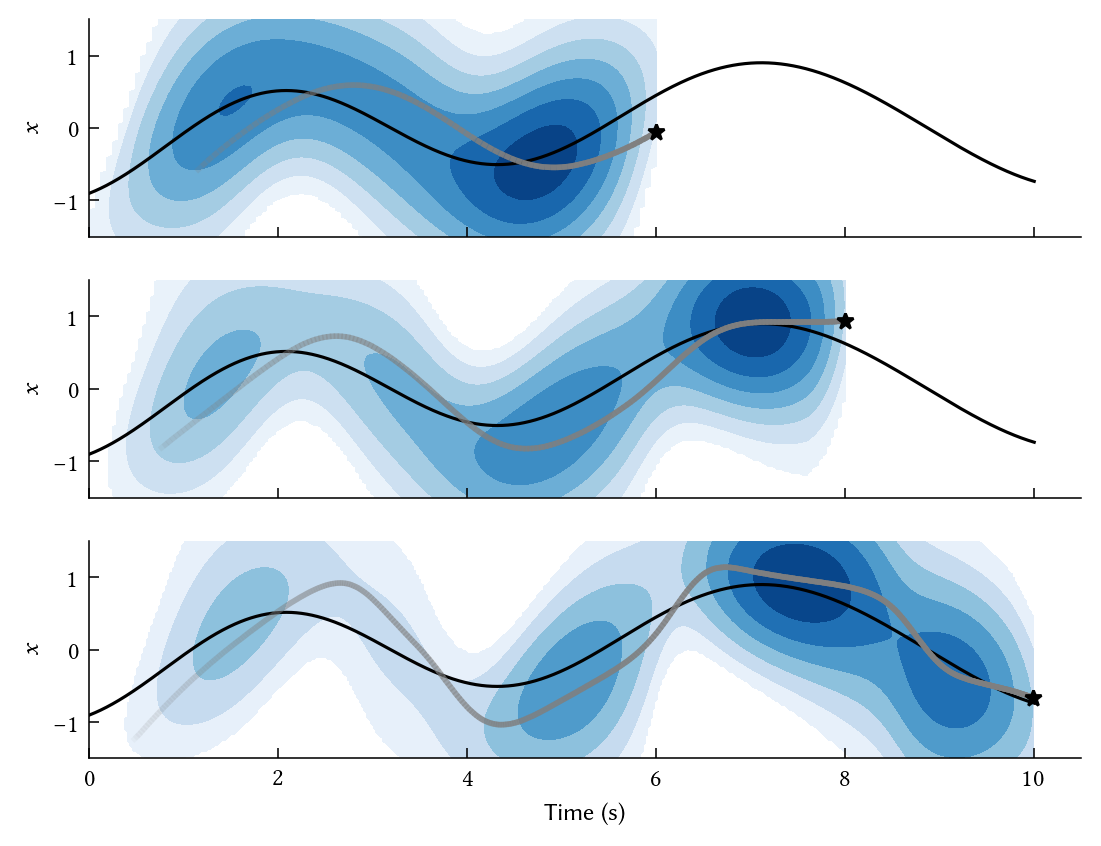

In [5]:
fig, axs = plt.subplots(nrows=3, sharex=True)

axs[0].plot(timesteps, path[:,0], color='k')
axs[1].plot(timesteps, path[:,0], color='k')
axs[2].plot(timesteps, path[:,0], color='k')
axs[2].set_xlabel('Time (s)')
for i in range(3):
    axs[i].set_ylabel('$x$')

xvalss = 1.5*np.linspace(-1,1,100)
simmin = 0.15
all_sims = []
for j, i in enumerate(sample_times):

    sims = []
    for k, t in enumerate(all_decode_times2[j]):
        splpts = np.vstack([xvalss, all_trajs2[j][1][k]*np.ones(100)]).T
        splssps = ssp_space.encode(splpts)
        res = t_space.bind(sim.data[tssp_p][i,:], t_space.encode(np.atleast_2d(t)))
        sims.append(res @ splssps.T)
    sims = np.array(sims).reshape(-1,100).T
    all_sims.append(sims)
    
    colss = axs[j].contourf(timesteps[i]+all_decode_times2[j],xvalss, 
                              np.ma.masked_where(sims< simmin, sims), vmin=simmin,cmap='Blues')
    
    alphas = np.linspace(1, 0, n_ts[j])
    for k in range(len(all_decode_times[j])):  
        if k>0:
            axs[j].plot(timesteps[i]+all_decode_times[j][k-1:k+1], all_trajs[j][0][k-1:k+1], 
                        alpha=alphas[k-1], color='gray', linewidth=2)
            
    #axs[j].set_facecolor(colss.cmap(0)[:-1])
    
    axs[j].plot(timesteps[i], all_trajs[j][0][0], '*', color='k')
    
    #axs[j].plot(timesteps[i]+decode_times, traj[:,0], alpha=-decode_times/5)

Saving to ssp_traj_heatmaps.large.pdf
Extracting bounding box of file ssp_traj_heatmaps.large.pdf
Optimising PDF and saving to ssp_traj_heatmaps.pdf


GPL Ghostscript 9.26: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.26: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.


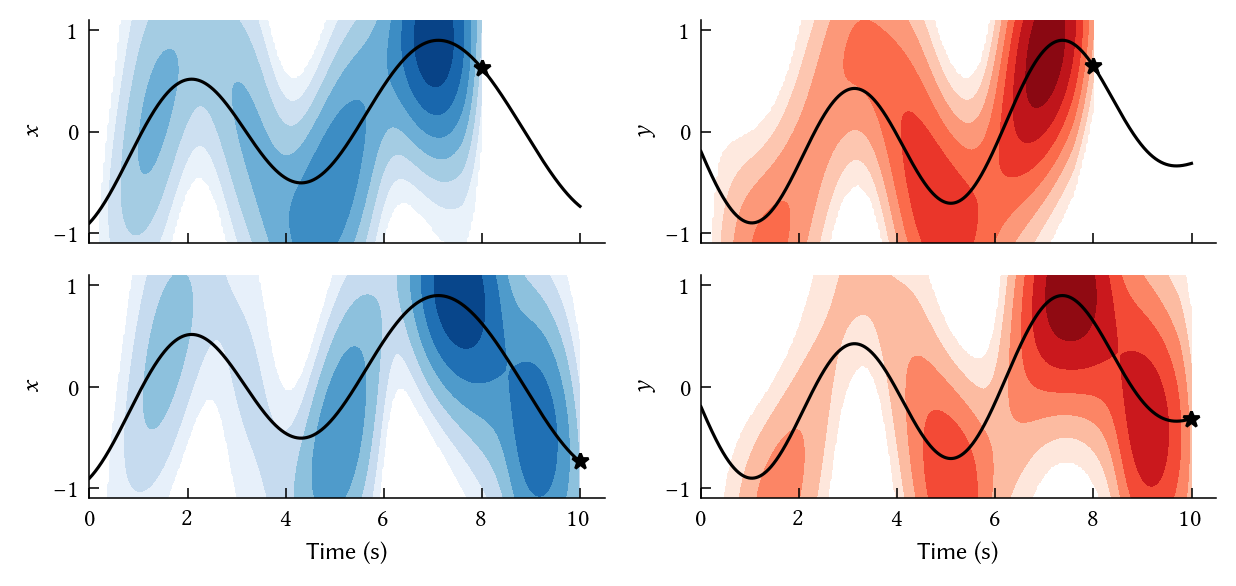

In [7]:


fig=plt.figure(figsize=(6.25, 3))
#fig, axs = plt.subplots(nrows=3, sharex=True)
gs = fig.add_gridspec(2,2)
axs = [plt.subplot(gs[0,0]), plt.subplot(gs[1,0])]
axs2 = [plt.subplot(gs[0,1]), plt.subplot(gs[1,1])]




axs[0].plot(timesteps, path[:,0], color='k')
axs[1].plot(timesteps, path[:,0], color='k')
axs[0].set_xticklabels([])
axs[1].set_xlabel('Time (s)')

axs2[0].plot(timesteps, path[:,1], color='k')
axs2[1].plot(timesteps, path[:,1], color='k')
axs2[0].set_xticklabels([])
axs2[1].set_xlabel('Time (s)')
for i in range(2):
    axs[i].set_ylabel('$x$')
    axs2[i].set_ylabel('$y$')

xvalss = np.linspace(-1.1,1.1,100)
simmin = 0.15
all_sims = []
for j, i in enumerate(sample_times[1:]):

    sims = []
    for k, t in enumerate(all_decode_times2[j+1]):
        splpts = np.vstack([xvalss, all_trajs2[j+1][1][k]*np.ones(100)]).T
        splssps = ssp_space.encode(splpts)
        res = t_space.bind(sim.data[tssp_p][i,:], t_space.encode(np.atleast_2d(t)))
        sims.append(res @ splssps.T)
    sims = np.array(sims).reshape(-1,100).T
    all_sims.append(sims)
    
    axs[j].contourf(timesteps[i]+all_decode_times2[j+1],xvalss, 
                              np.ma.masked_where(sims< simmin, sims), vmin=simmin,cmap='Blues')
    
    
    alphas = np.linspace(1, 0, n_ts[j])
    axs[j].plot(timesteps[i], path[i,0], '*', color='k')

for j, i in enumerate(sample_times[1:]):

    sims = []
    for k, t in enumerate(all_decode_times2[j+1]):
        splpts = np.vstack([all_trajs2[j+1][0][k]*np.ones(100), xvalss]).T
        splssps = ssp_space.encode(splpts)
        res = t_space.bind(sim.data[tssp_p][i,:], t_space.encode(np.atleast_2d(t)))
        sims.append(res @ splssps.T)
    sims = np.array(sims).reshape(-1,100).T
    
    axs2[j].contourf(timesteps[i]+all_decode_times2[j+1],xvalss, 
                              np.ma.masked_where(sims< simmin, sims), vmin=simmin,cmap='Reds')
    
    
    alphas = np.linspace(1, 0, n_ts[j])
    axs2[j].plot(timesteps[i], path[i,1], '*', color='k')



fig.tight_layout()
utils.save(fig, "ssp_traj_heatmaps.pdf")

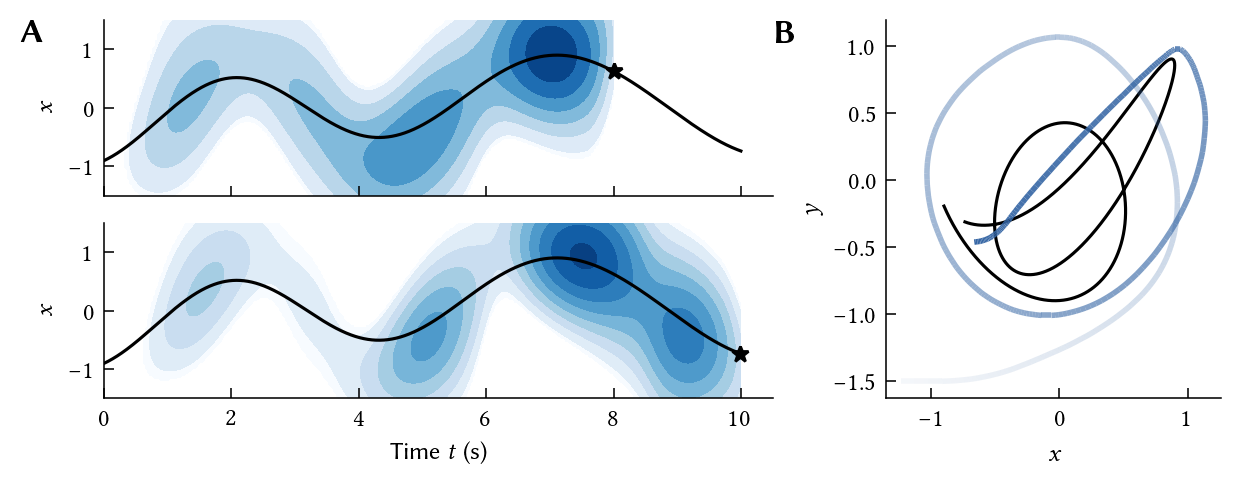

In [8]:


fig=plt.figure(figsize=(6.2, 2.5))
#fig, axs = plt.subplots(nrows=3, sharex=True)
gs = fig.add_gridspec(2,2, width_ratios=[2,1])
axs = [plt.subplot(gs[0,0]), plt.subplot(gs[1,0])]


ax = plt.subplot(gs[:,1])
ax.plot( path[:,0], path[:,1], color='k')

axs[0].plot(timesteps, path[:,0], color='k')
axs[1].plot(timesteps, path[:,0], color='k')
axs[0].set_xticklabels([])
axs[1].set_xlabel('Time $t$ (s)')
for i in range(2):
    axs[i].set_ylabel('$x$')

xvalss = np.linspace(-1.5,1.5,100)
simmin = 0.25
all_sims = []
for j, i in enumerate(sample_times[1:]):

    sims = []
    for k, t in enumerate(all_decode_times2[j+1]):
        splpts = np.vstack([xvalss, all_trajs2[j+1][1][k]*np.ones(100)]).T
        splssps = ssp_space.encode(splpts)
        res = t_space.bind(sim.data[tssp_p][i,:], t_space.encode(np.atleast_2d(t)))
        sims.append(res @ splssps.T)
    sims = np.array(sims).reshape(-1,100).T
    all_sims.append(sims)
    #contourf
    colss = axs[j].contourf(timesteps[i]+all_decode_times2[j+1],xvalss, 
                              np.ma.masked_where(sims< simmin, sims), vmin=simmin,cmap='Blues')
    
    alphas = np.linspace(1, 0, n_ts[j+1])
    axs[j].plot(timesteps[i], path[i,0], '*', color='k')

for k in range(len(all_decode_times[-1])):  
        if k>0:
            ax.plot(all_trajs[-1][0][k-1:k+1], all_trajs[-1][1][k-1:k+1], '--',
                alpha=alphas[k-1],linewidth=2,color=utils.blues[1],markersize=1, zorder=2 )

fig.text(0.01, 0.9, '\\textbf{A}', size=12, va="baseline", ha="left")
fig.text(0.62,0.9, '\\textbf{B}', size=12, va="baseline", ha="left")

    
ax.set_ylabel("$y$") 
ax.set_xlabel("$x$") 

fig.tight_layout()

# utils.save(fig, "ssp_traj_v2.pdf")